## About this notebook

Using DAPI segmentation to estimate spheroid centroid and then quantify migration area using cytokleton staining.

+ With DAPI stain, spheroid were identified with area > 1800 um^2 (the size of the seeding area of the spheroid, designed by the micropatten of area 1800 um^2).
+ Expend 250 um (which is half of the distance between neighbouring micro-islands of size 1800 um^2) and get cell area within the expanded area (by cytoskeleton stains).
+ Since the cell area segmentation is crucial for the migration quantification, we first use cellpose to segment cells and then have an additional rule-based segmentation to refine the segmentation mask.


In [1]:
import os
import glob
from skimage import io
from skimage.filters import threshold_otsu, gaussian, threshold_triangle, threshold_li
from skimage.measure import label, regionprops
import numpy as np
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tifffile
from scipy.ndimage import distance_transform_edt
from skimage.draw import disk


In [2]:
pixel_size = 1.5535 #um/px
spheroid_area_threshold = 2000/pixel_size/pixel_size
expansion_size = 250/pixel_size

In [3]:
file_names = glob.glob('**/*.tif', recursive=True)
file_names_tmp = []
for file_name in file_names:
    if ('DAPI' in file_name) or ('GFP' in file_name) or ('masks' in file_name):
        continue
    file_names_tmp.append(file_name)
file_names = file_names_tmp

In [4]:
len(file_names)

623

In [5]:
file_names

['EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0028.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0029.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0022.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0023.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0027.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0026.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0024.tif',
 'EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0025.tif',
 'EVOS-spheroid/15.11.2023 KASH 

In [7]:
## command line code for cellpose segmentation
with open('cellpose_code.sh', 'w') as f:
    # f.write('This is a new line.\n')
    for file_name in file_names:
        if ('DAPI' in file_name) or ('GFP' in file_name):
            continue
        f.write(f'python -m cellpose --image_path="{file_name}"  --pretrained_model=/Volumes/Luezhen/other-analysis/Hui-project/EVOS-Cellpose/models/CP_EVOS_20241011_232941 --save_tif --verbose --chan 2 --chan2 1 --diameter 30\n')

In [12]:
## Adjust the cytoskeleton segmentation
## Add rule based segmentation on top
threshold_overlap = 0.9
for file_name in tqdm(file_names):
    if ('DAPI' in file_name) or ('GFP' in file_name):
        continue
    m_img = io.imread(file_name)
    ## cytoskeleton segmentation
    m_img_1_smooth = gaussian(m_img[1], sigma=1 , preserve_range=True)
    m_img_1_mask = m_img_1_smooth > threshold_triangle(m_img_1_smooth)
    ## read in cellpose segmentation results
    m_img_cellpose = io.imread(file_name[:-4] + '_cp_masks.tif')
    m_img_1_label = label(m_img_1_mask)
    regions = regionprops(m_img_1_label, intensity_image=m_img_cellpose)
    # remove cellpose segments from rule based segments
    for props in regions:
        # if majority of the cellpose segmentation overlaps rule based method
        # remove this segment
        if sum(sum(props.image_intensity > 0)) >= (props.area*threshold_overlap):
            minr, minc, maxr, maxc = props.bbox
            m_img_1_label[minr:maxr, minc:maxc][props.image] = 0
    m_img_1_label = m_img_1_label * (m_img_cellpose==0) # region outside cellpose segmentation
    regions = regionprops(label(m_img_1_label>0))
    m_img_1_adj = m_img_cellpose.copy()
    m_img_1_idx_max = np.max(m_img_cellpose)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        m_img_1_adj[minr:maxr, minc:maxc][props.image] = props.label + m_img_1_idx_max

    ## save adjusted segmentation image
    tifffile.imwrite(f'{file_name[:-4]}-adjust-masks.tif', m_img_1_adj.astype('uint32'), metadata={'axes': 'YX'}, compression ='zlib')

100%|██████████| 623/623 [03:24<00:00,  3.05it/s]


In [6]:
def find_spheroid_centroids(file_name, pixel_size=pixel_size, spheroid_area_threshold=spheroid_area_threshold, expansion_size=expansion_size, plot=True):
    # Read image
    m_img = io.imread(file_name)
    m_label = label(gaussian(m_img[0],sigma=2, preserve_range=True) > threshold_otsu(m_img[0]))

    # Get region properties
    regions = regionprops(m_label)
    spheroid_expansion_mask = np.zeros_like(m_label)

    # Create the expansion mask
    for props in regions:
        if props.area > spheroid_area_threshold:
            row, col = np.uint32(props.centroid)
            spheroid_expansion_mask[row, col] = props.label

    # Expand labels
    spheroid_expansion_mask = expand_labels(spheroid_expansion_mask, distance=expansion_size)

    # Plotting
    if plot==True:
        plt.figure(figsize=(5, 5), dpi=500)
        plt.imshow(spheroid_expansion_mask)
        
        # Overlay centroids with red crosses
        for props in regions:
            if props.area > spheroid_area_threshold:
                row, col = np.uint32(props.centroid)
                plt.plot(col, row, 'rx', markersize=10)  # Red cross

        plt.title('')
        plt.axis('off')  # Turn off axis
        plt.show()
    return spheroid_expansion_mask

In [7]:
def remove_inner_cor(spheroid_label, cell_label):
    regions = regionprops(spheroid_label, intensity_image=cell_label)
    cell_label_remove_cor = cell_label.copy()
    inner_core = np.zeros_like(cell_label)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        tmp_label = label(props.image_intensity>0)
        tmp_centroid = np.array(tmp_label.shape) //2
        if tmp_label[tmp_centroid[0],tmp_centroid[1]] == 0:
            continue
        tmp_label_core = (tmp_label==tmp_label[tmp_centroid[0],tmp_centroid[1]])
        distance_transform = distance_transform_edt(tmp_label_core)
        max_radius = np.max(distance_transform)
        center_coords = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
        circle_image = np.zeros_like(tmp_label_core)
        rr, cc = disk(center_coords, max_radius, shape=circle_image.shape)
        circle_image[rr, cc] = 1  # Set the pixels within the circle to 1
        cell_label_remove_cor[minr:maxr, minc:maxc][circle_image] = 0
        inner_core[minr:maxr, minc:maxc][circle_image] = 1

    return cell_label_remove_cor,inner_core

In [36]:
quantification_df = pd.DataFrame()
for file_name in tqdm(file_names):
    if ('DAPI' in file_name) or ('GFP' in file_name):
        continue
    condition = file_name.rsplit('/',1)[0]
    m_img = io.imread(file_name)
    spheroid_expansion_mask = find_spheroid_centroids(file_name, plot=False)
    ## measure cytoskeleton area
    ## cytoskeleton segmentation
    m_img_1_mask = io.imread(f'{file_name[:-4]}-adjust-masks.tif')
    m_img_1_mask_remove_cor,inner_core = remove_inner_cor(spheroid_expansion_mask,m_img_1_mask)
    m_img_1_mask = m_img_1_mask>0
    regions = regionprops(spheroid_expansion_mask, intensity_image=m_img_1_mask)
    current_df = pd.DataFrame()
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        tmp_df = pd.DataFrame({
            'expasion_area':props.area*pixel_size*pixel_size,
            'cytoskeleton_area':sum(sum(props.image_intensity>0))*pixel_size*pixel_size,
            'inner_core_area':sum(inner_core[minr:maxr, minc:maxc][props.image]>0)*pixel_size*pixel_size
            }, index=[0])
        tmp_df['cytoskeleton_ratio'] = (tmp_df['cytoskeleton_area'] - tmp_df['inner_core_area'])/(tmp_df['expasion_area'] - tmp_df['inner_core_area'])
        current_df = pd.concat([current_df, tmp_df], axis=0, ignore_index=True)
    current_df['condition'] = condition
    quantification_df = pd.concat([quantification_df, current_df], axis=0, ignore_index=True)



100%|██████████| 623/623 [03:53<00:00,  2.66it/s]


In [14]:
for i in range(len(file_names)):
    print(f"{i}  {file_names[i]}")

0  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0028.tif
1  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0029.tif
2  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0022.tif
3  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0023.tif
4  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0027.tif
5  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0026.tif
6  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0024.tif
7  EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin/vimentin inhibitor 4x_0025.tif
8  EVOS-spheroid/15.11.2023 KASH G, HPI4

In [37]:
quantification_df

expasion_area  cytoskeleton_area  inner_core_area  cytoskeleton_ratio  \
0     170564.377019       35254.395748     15669.961089            0.126437   
1     166251.698678       17381.034925      9955.119281            0.047512   
2     185971.281623       87298.552669     39108.535261            0.328130   
3     182037.501155       50509.258530     18257.085421            0.196923   
4     166893.653037      137264.804693     86526.276749            0.631332   
...             ...                ...              ...                 ...   
5005  196285.991879       74242.262897     16471.197356            0.321281   
5006  196285.991879       55200.834744      2743.992878            0.271036   
5007  196196.697476       82884.513114     11876.155632            0.385244   
5008  196285.991879       64463.319060      7995.469134            0.299897   
5009  196285.991879       46172.446567      4829.137862            0.215941   

                                              condition  
0     EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin...  
1     EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin...  
2     EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin...  
3     EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin...  
4     EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin...  
...                                                 ...  
5005  EVOS-spheroid/ERK inhibitors/09.03.2024 batch4...  
5006  EVOS-spheroid/ERK inhibitors/09.03.2024 batch4...  
5007  EVOS-spheroid/ERK inhibitors/09.03.2024 batch4...  
5008  EVOS-spheroid/ERK inhibitors/09.03.2024 batch4...  
5009  EVOS-spheroid/ERK inhibitors/09.03.2024 batch4...  

[5010 rows x 5 columns]

In [38]:
for i in quantification_df['condition'].unique():
    print(i)

EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/vimentin
EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/hpi4
EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/k unload
EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/g unload
EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/k load
EVOS-spheroid/15.11.2023 KASH G, HPI4,vimentin inhibitor, 4x check migration/g load
EVOS-spheroid/Drug treatment   2 day/Latrunculin A
EVOS-spheroid/Drug treatment   2 day/PD98059
EVOS-spheroid/Drug treatment   2 day/control group
EVOS-spheroid/Drug treatment   2 day/PF573228
EVOS-spheroid/Drug treatment   2 day/dmso-1
EVOS-spheroid/Drug treatment   2 day/experimental group
EVOS-spheroid/Drug treatment   2 day/Ku55933
EVOS-spheroid/Drug treatment   2 day/CytochalasinD
EVOS-spheroid/Drug treatment   2 day/Nocodazole
EVOS-spheroid/Drug treatment   2 day/Y27632
EVOS-sphero

In [39]:
quantification_df.to_csv('cytoskeleton_area_ratio.csv')

## Just for checking the quality of identification of spheroid center and image quality, no need to run!

+ Clusters of nucleus were identified as individual spheroids. The center were also identified.
+ Check the quality of cell area segmentation.
+ Check the quality of removing dense inner core of the spheroids (i.e. remove_inner_cor function), which is not very relevant for the cell migration area quantification.
+ Here, I also showed several rule-based segmentation results.


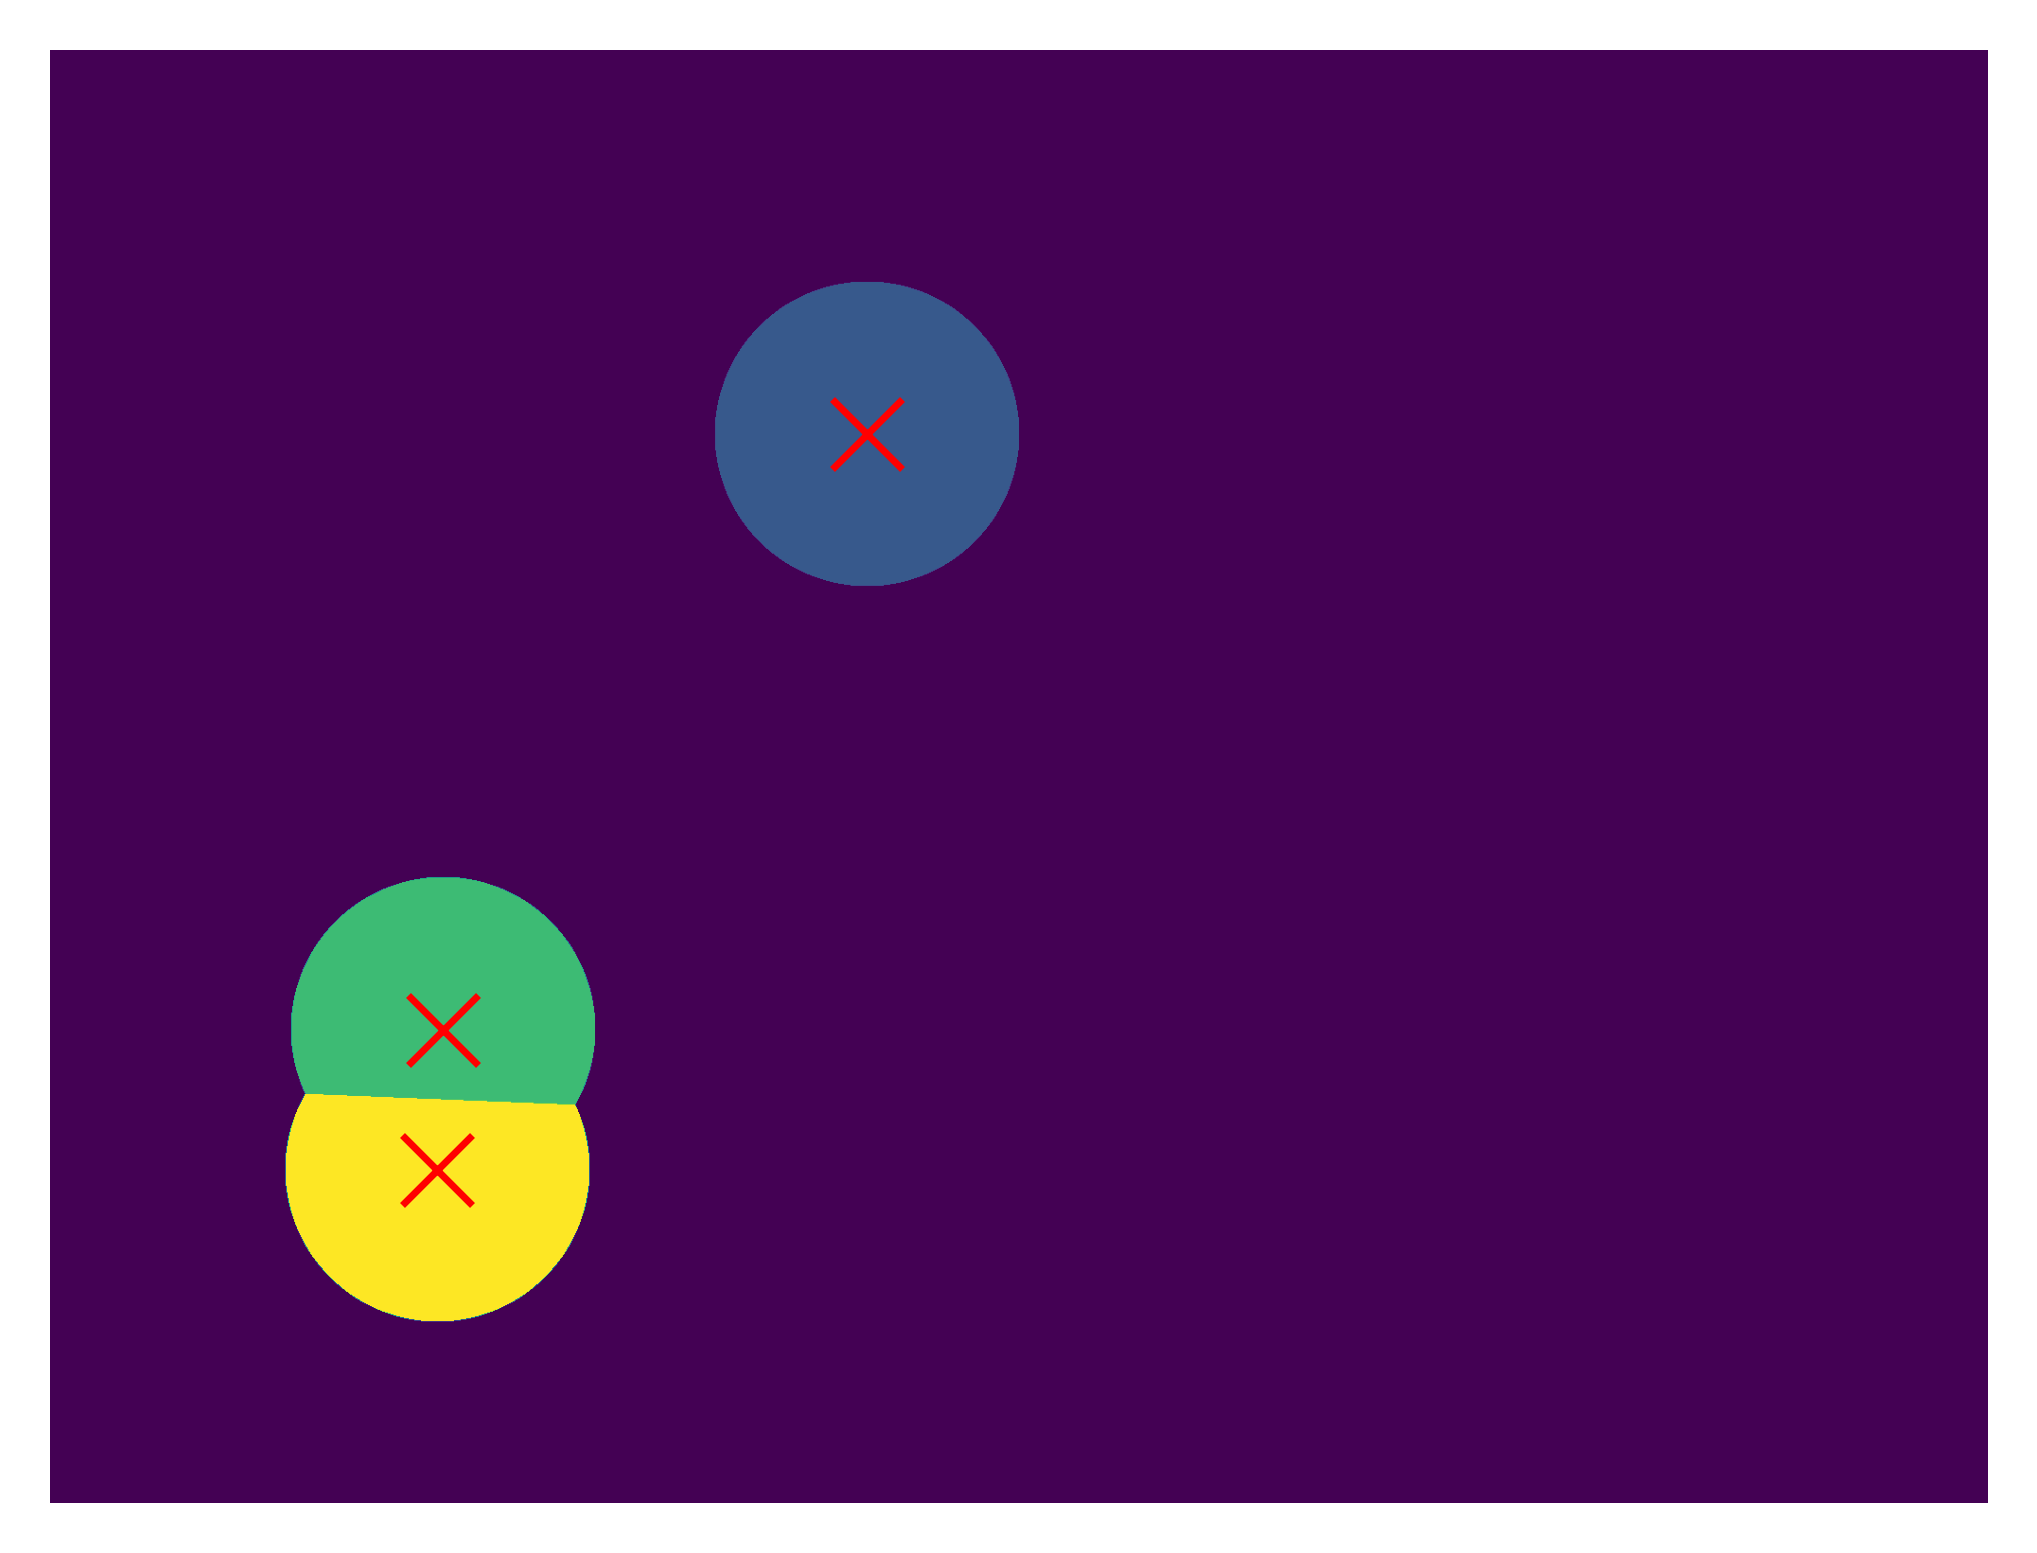

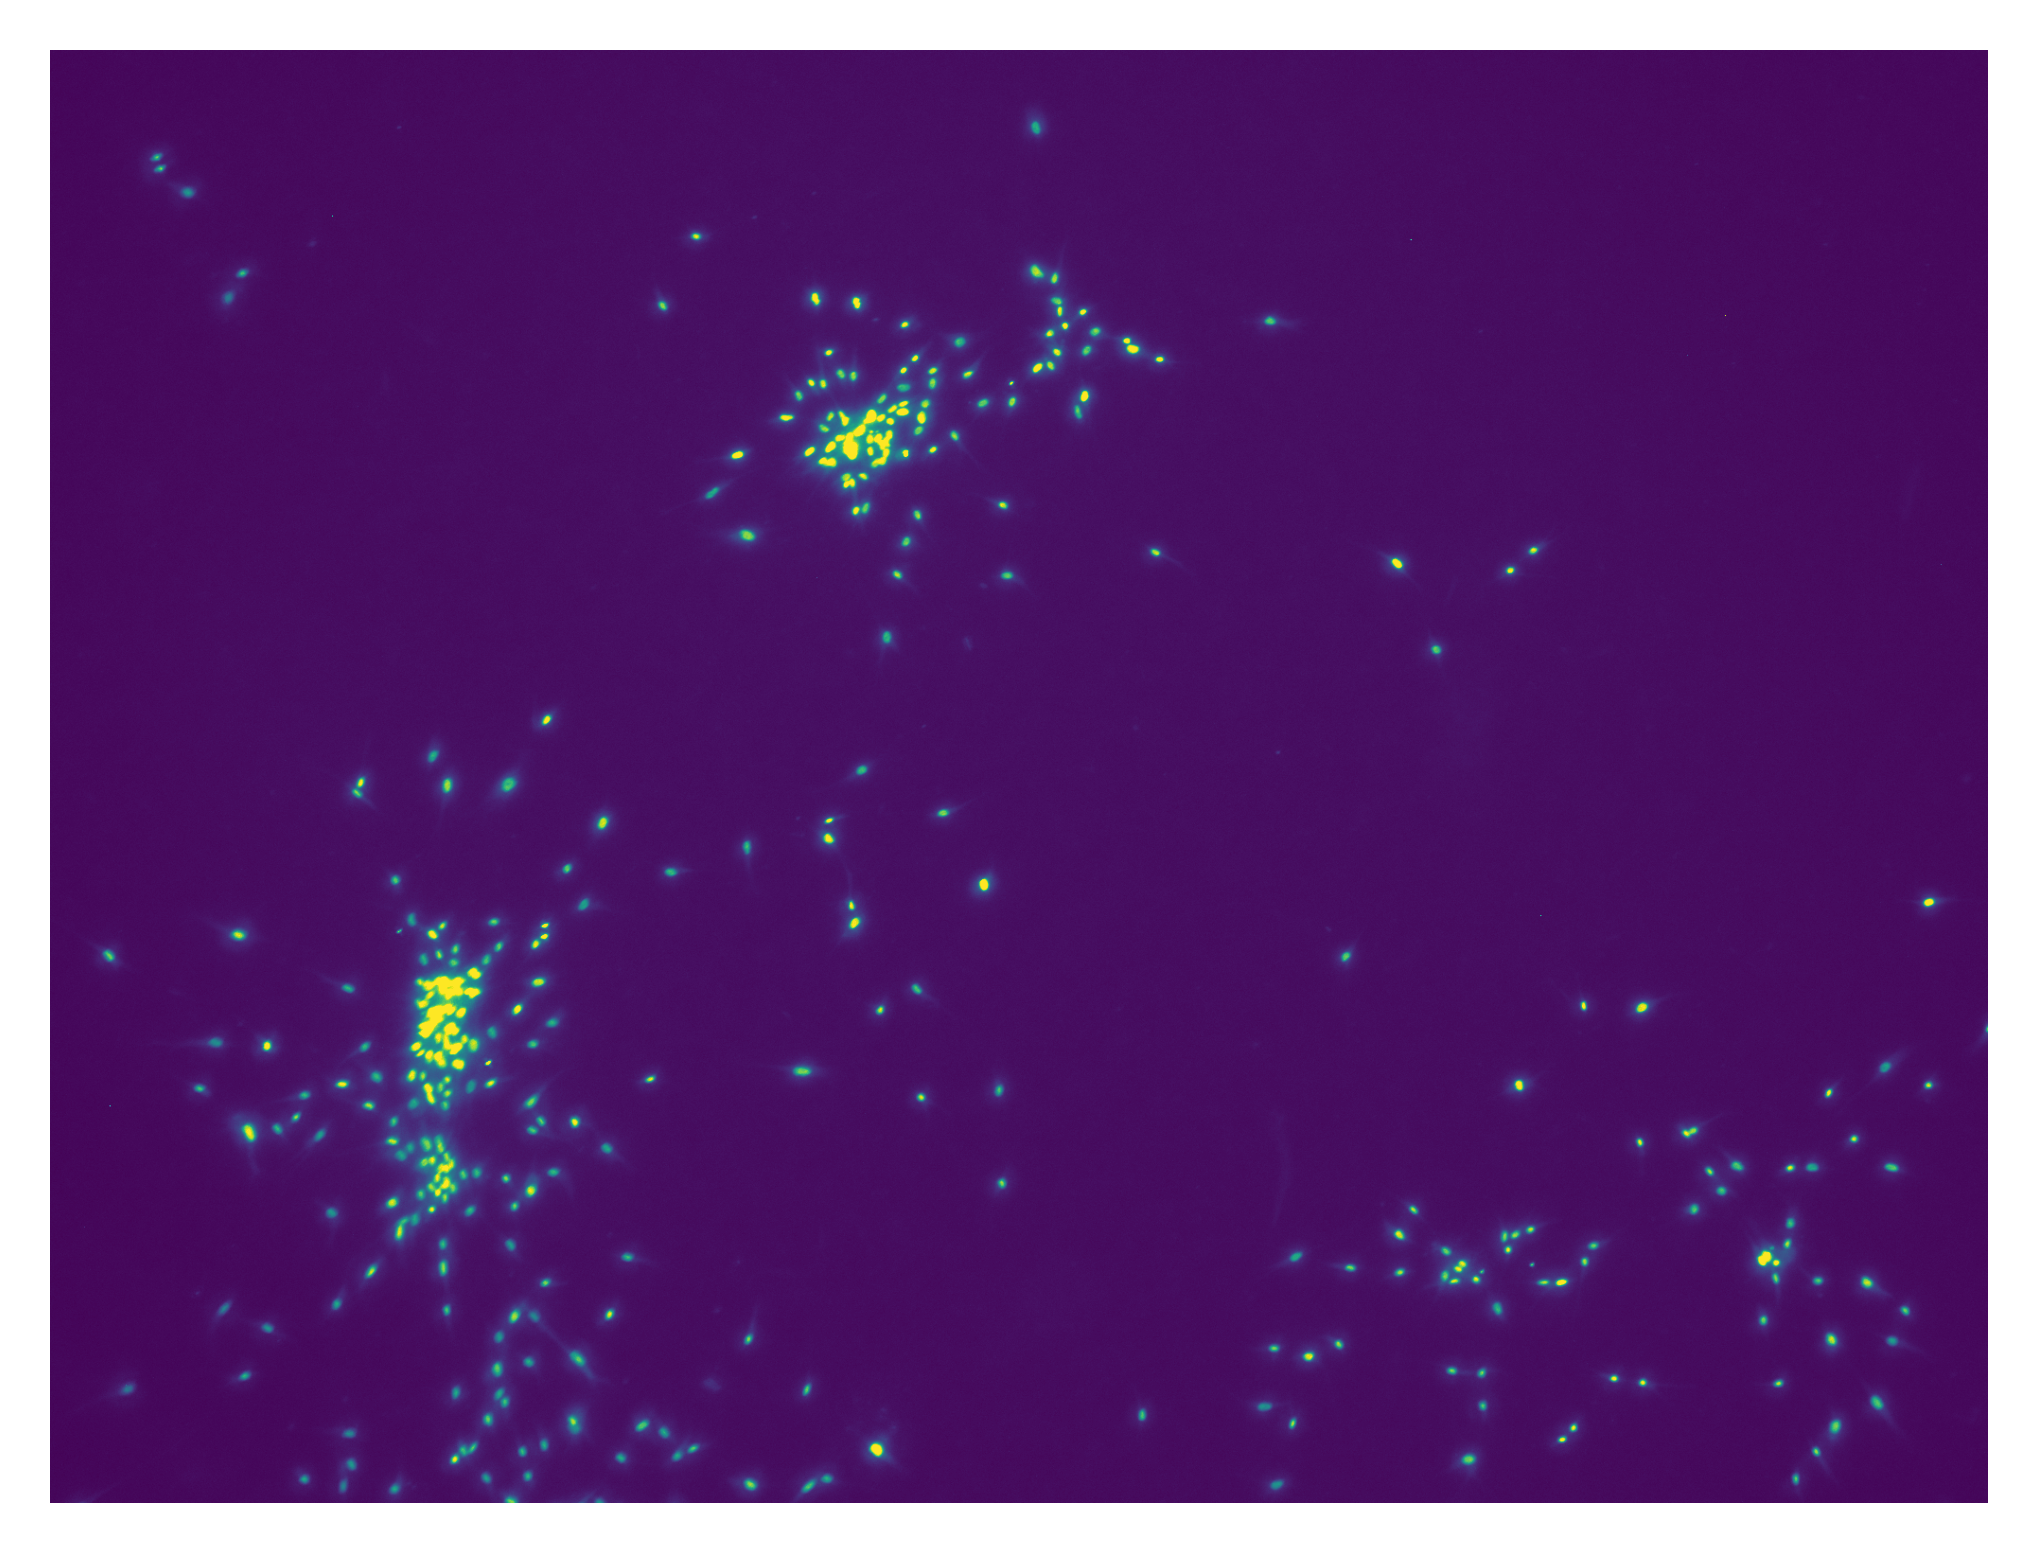

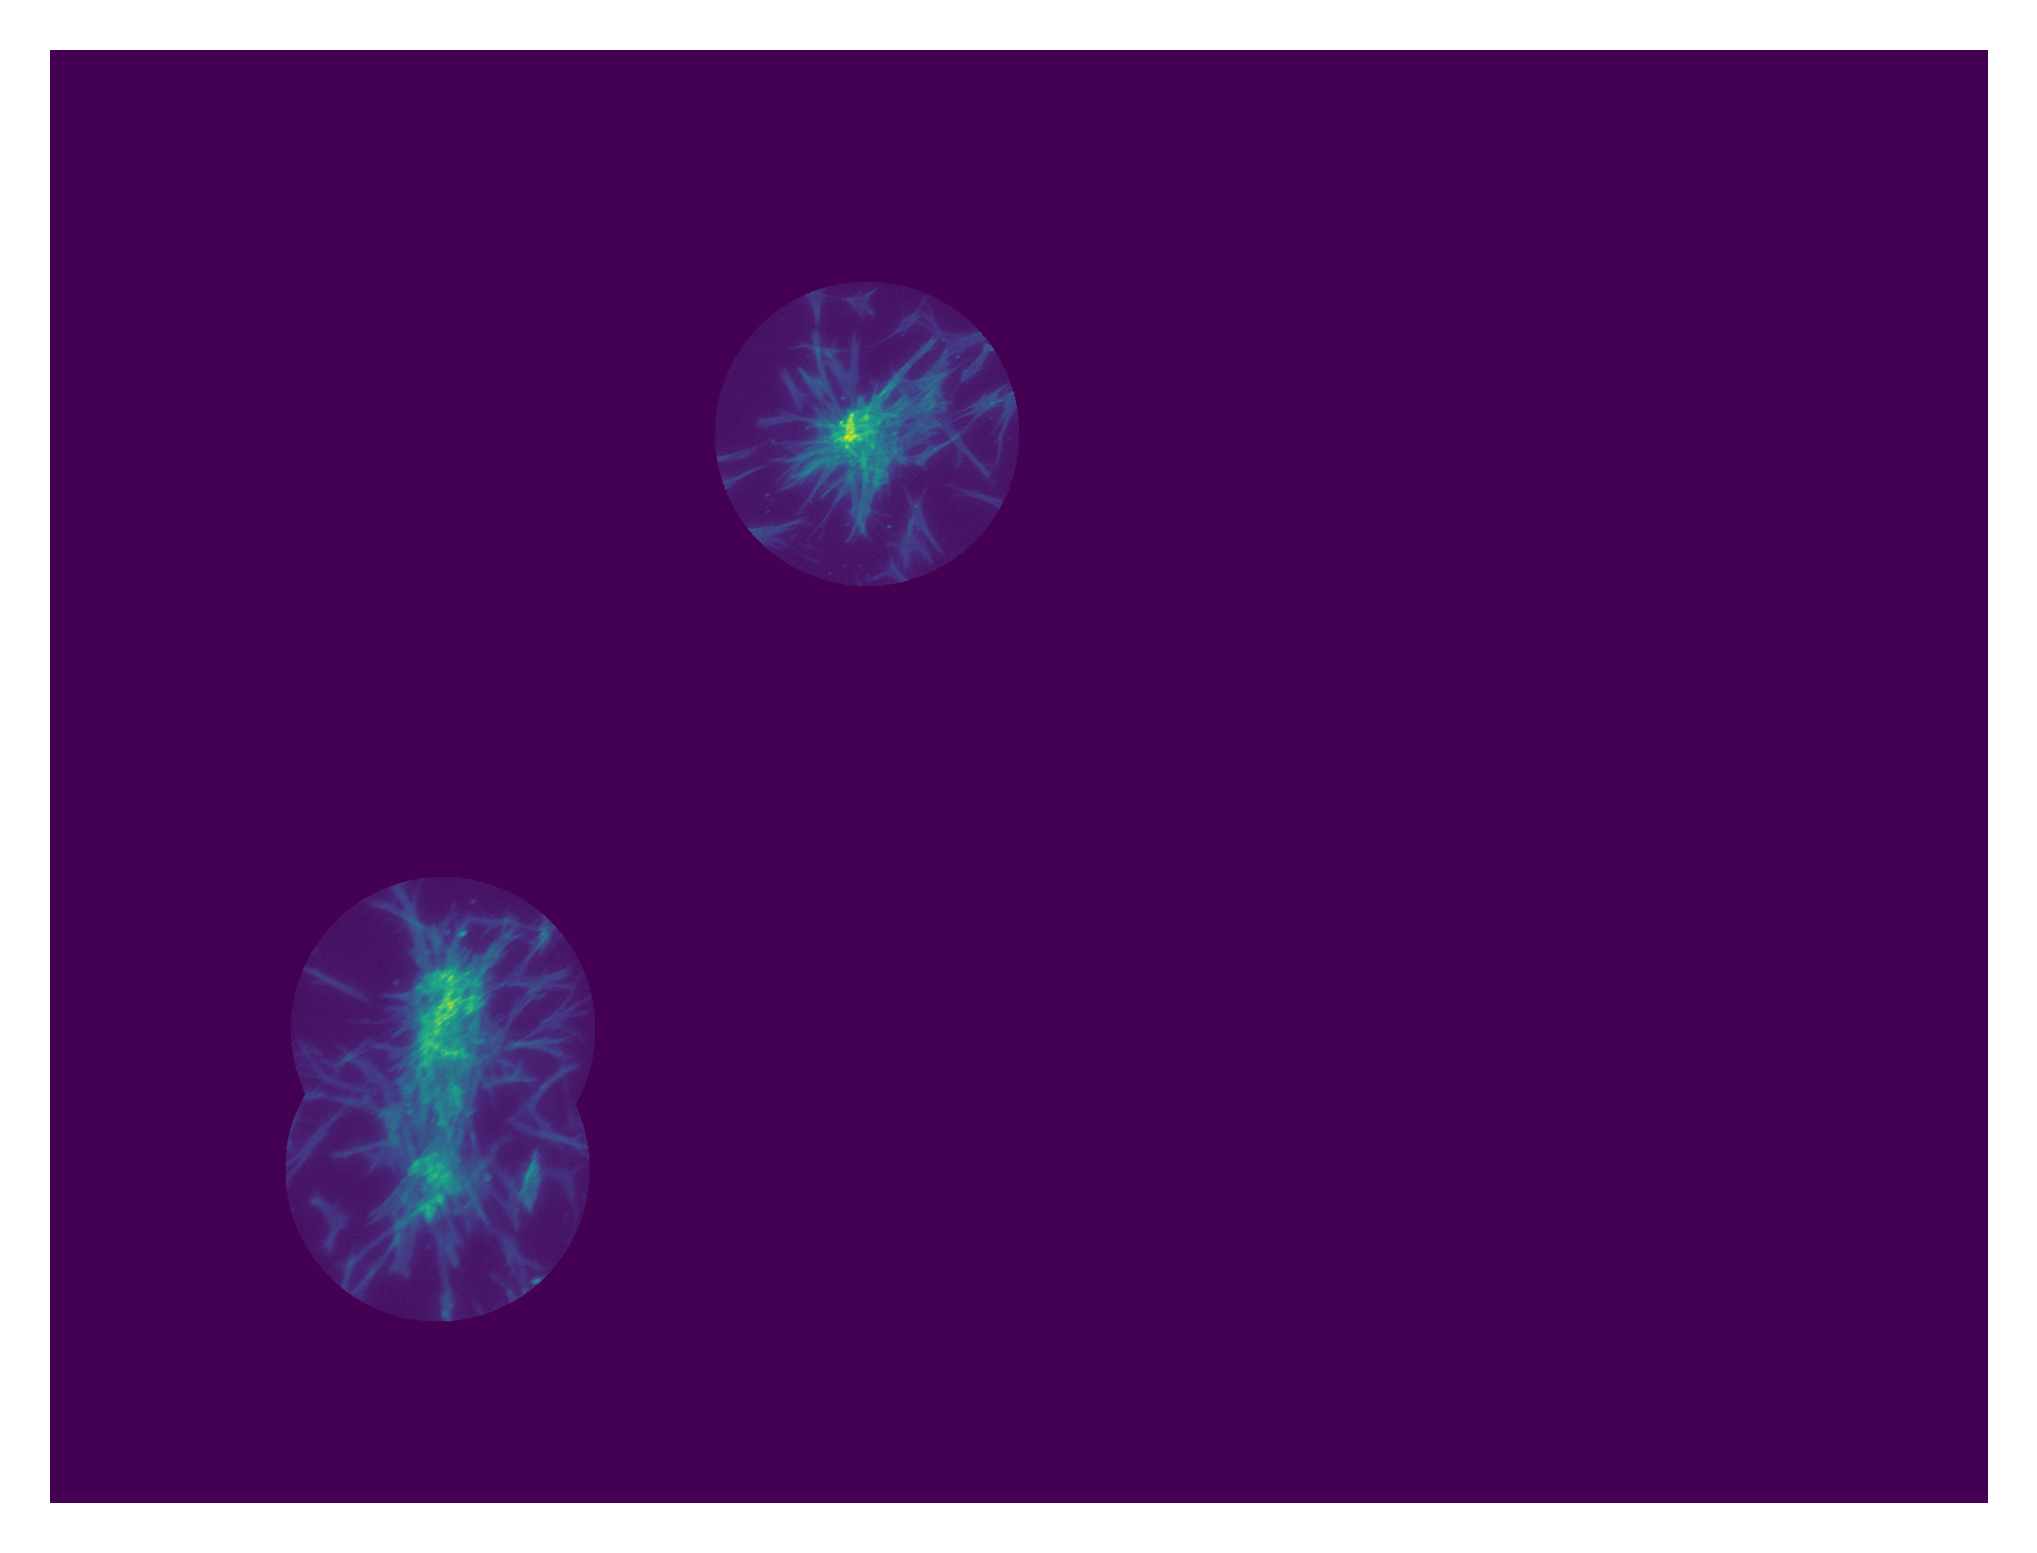

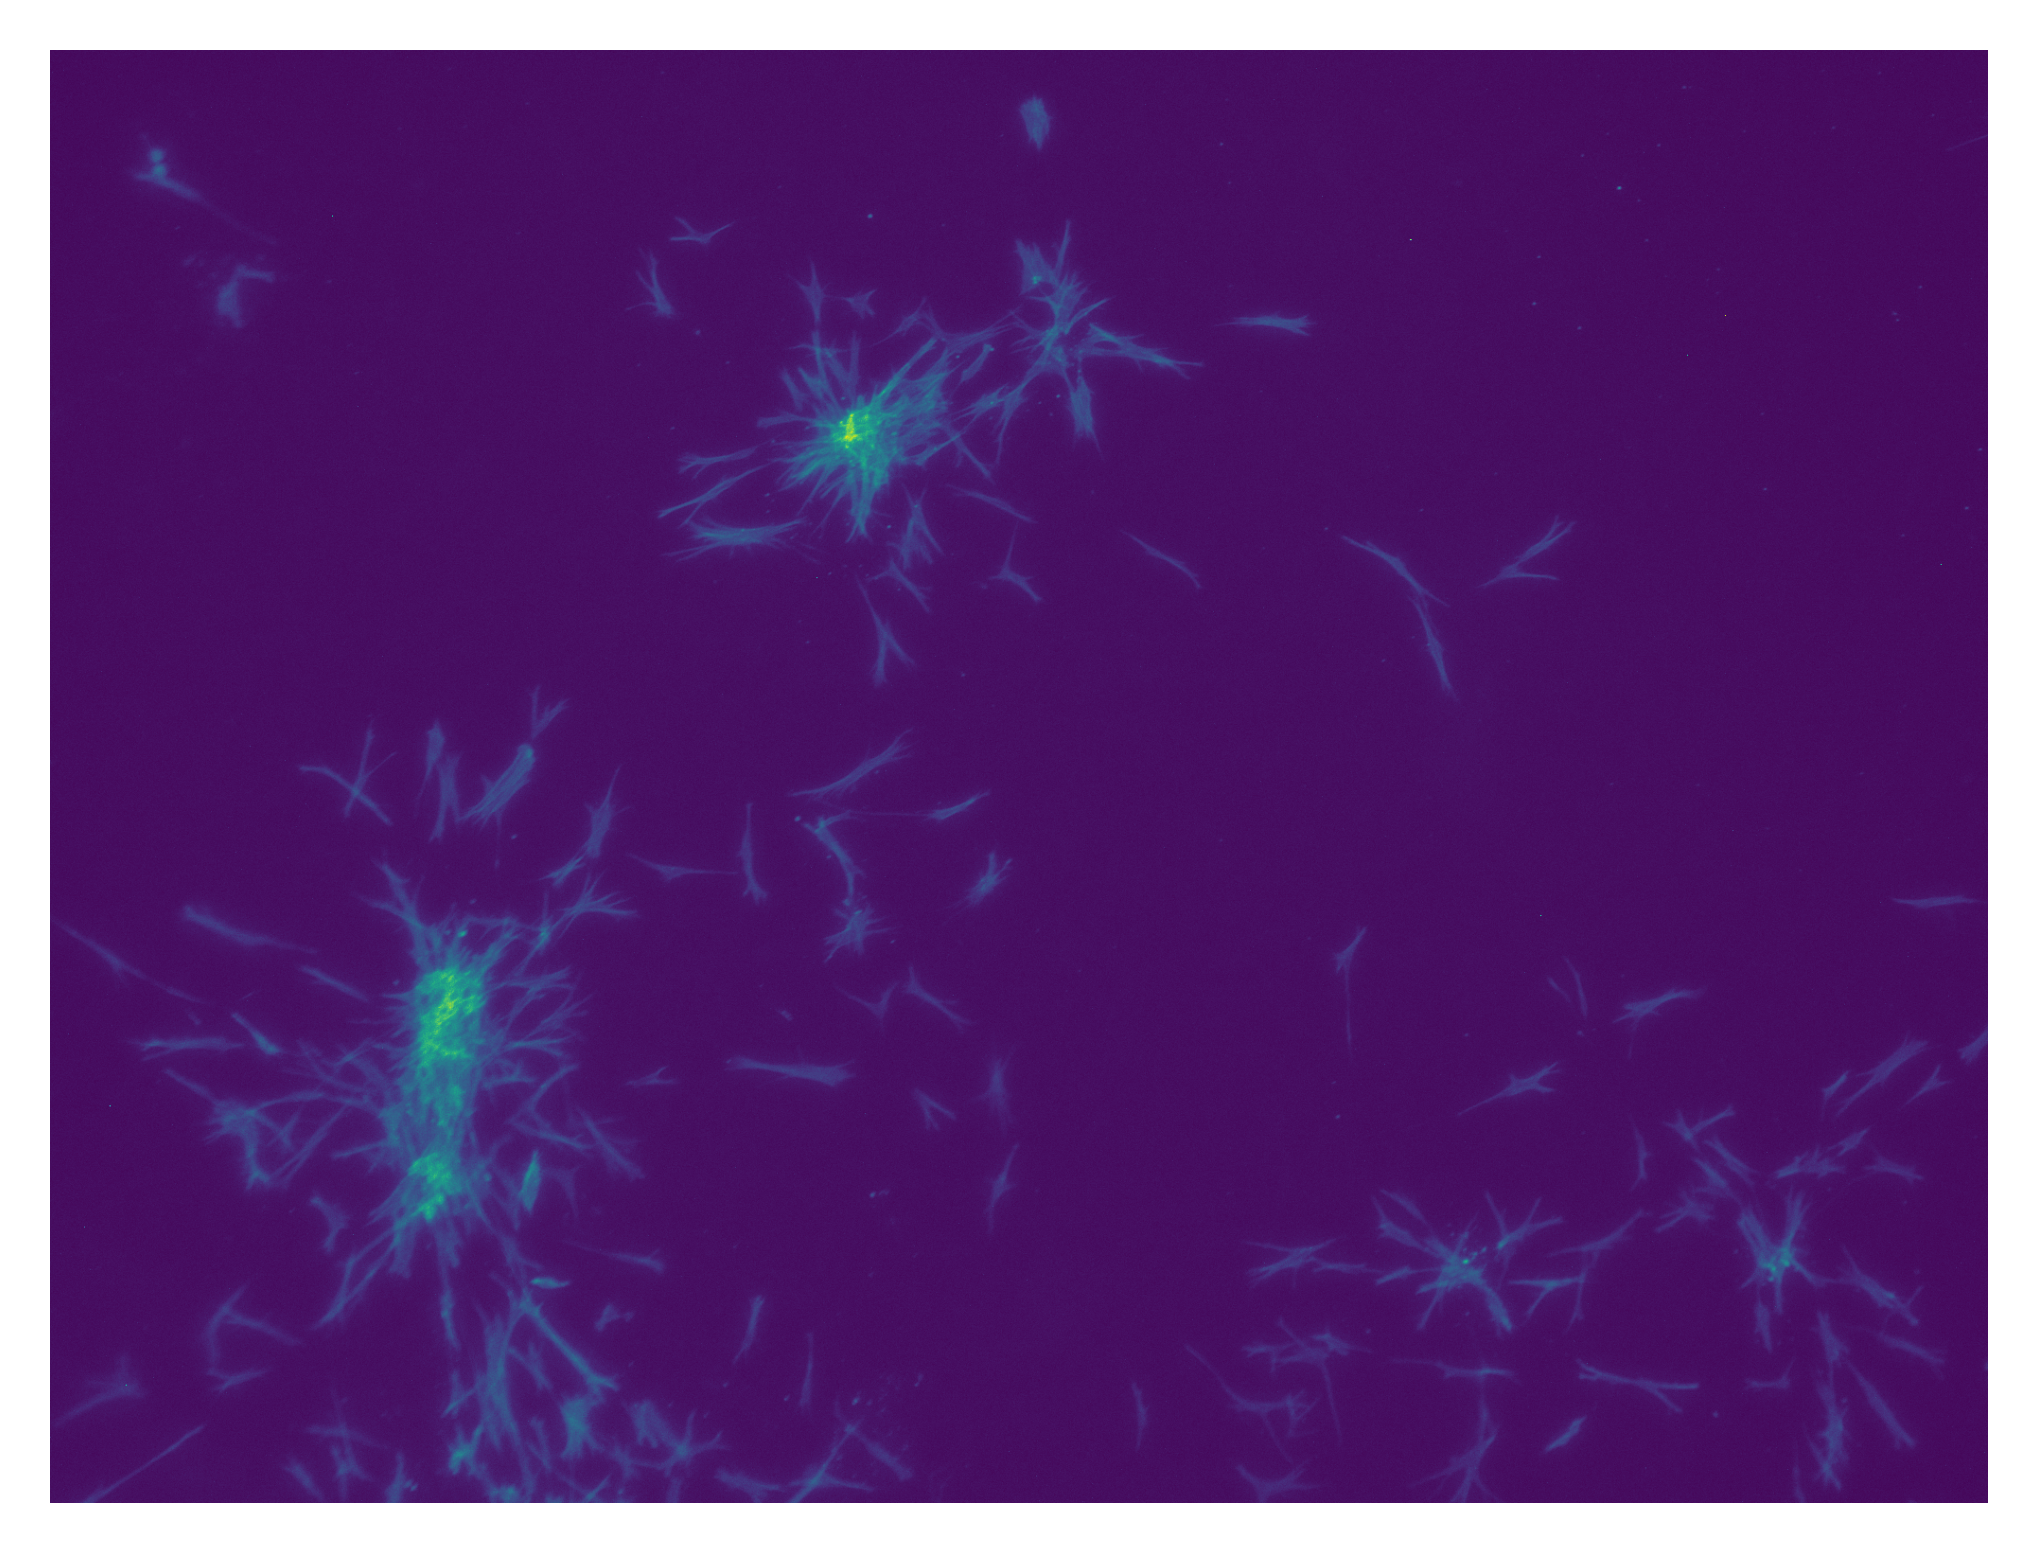

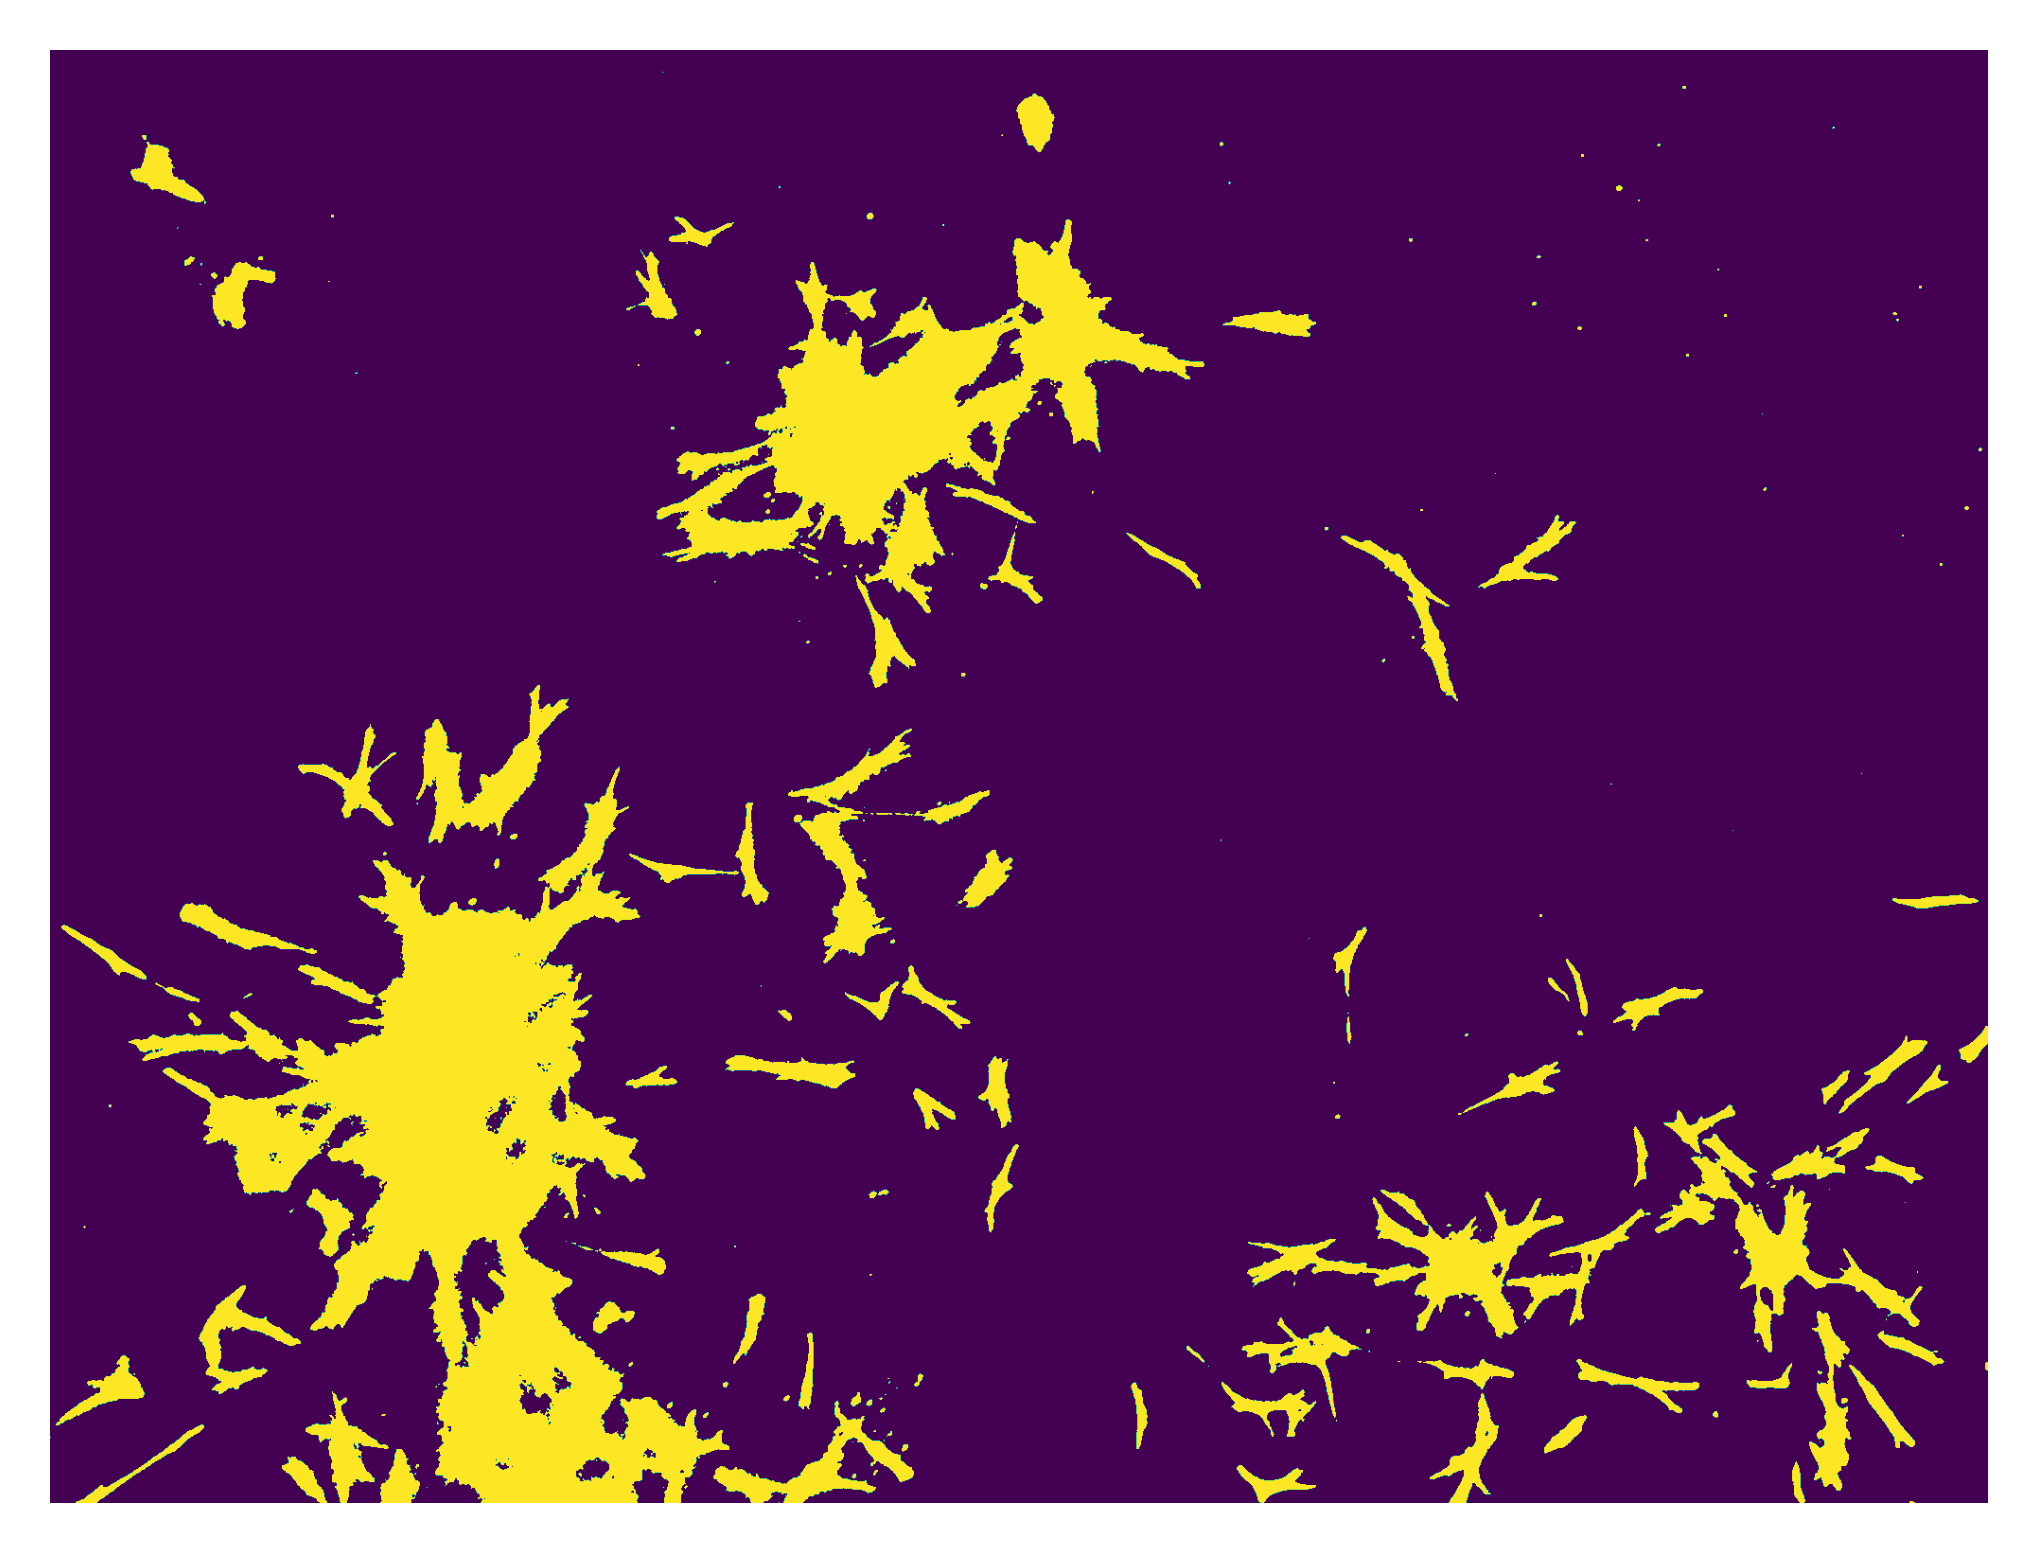

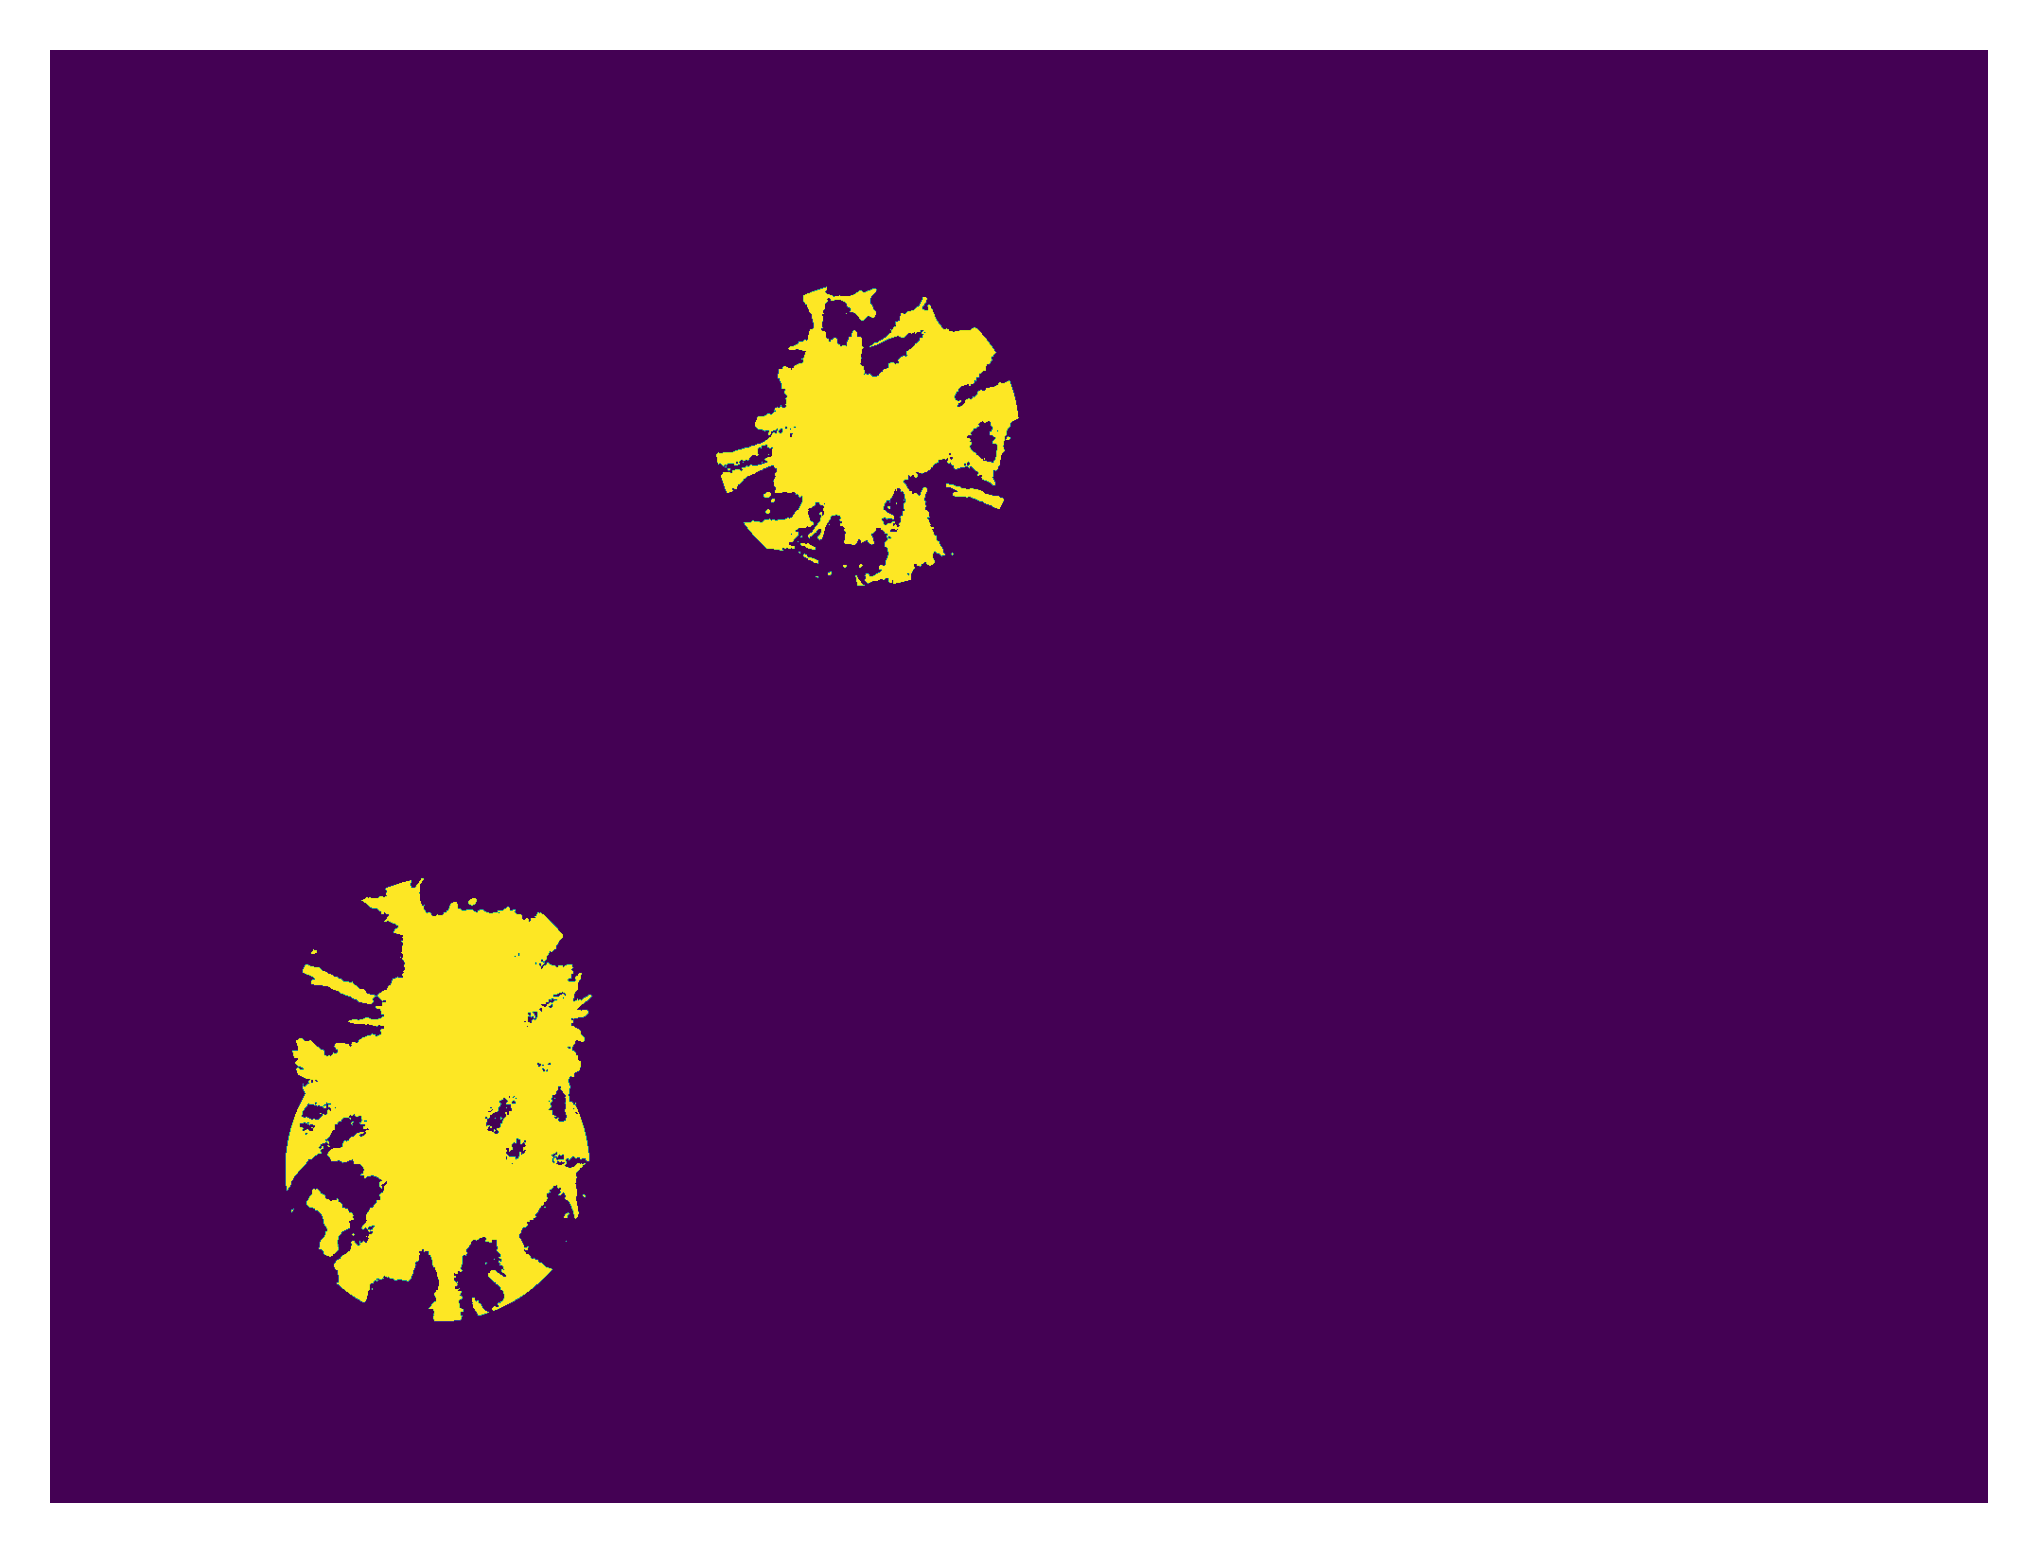

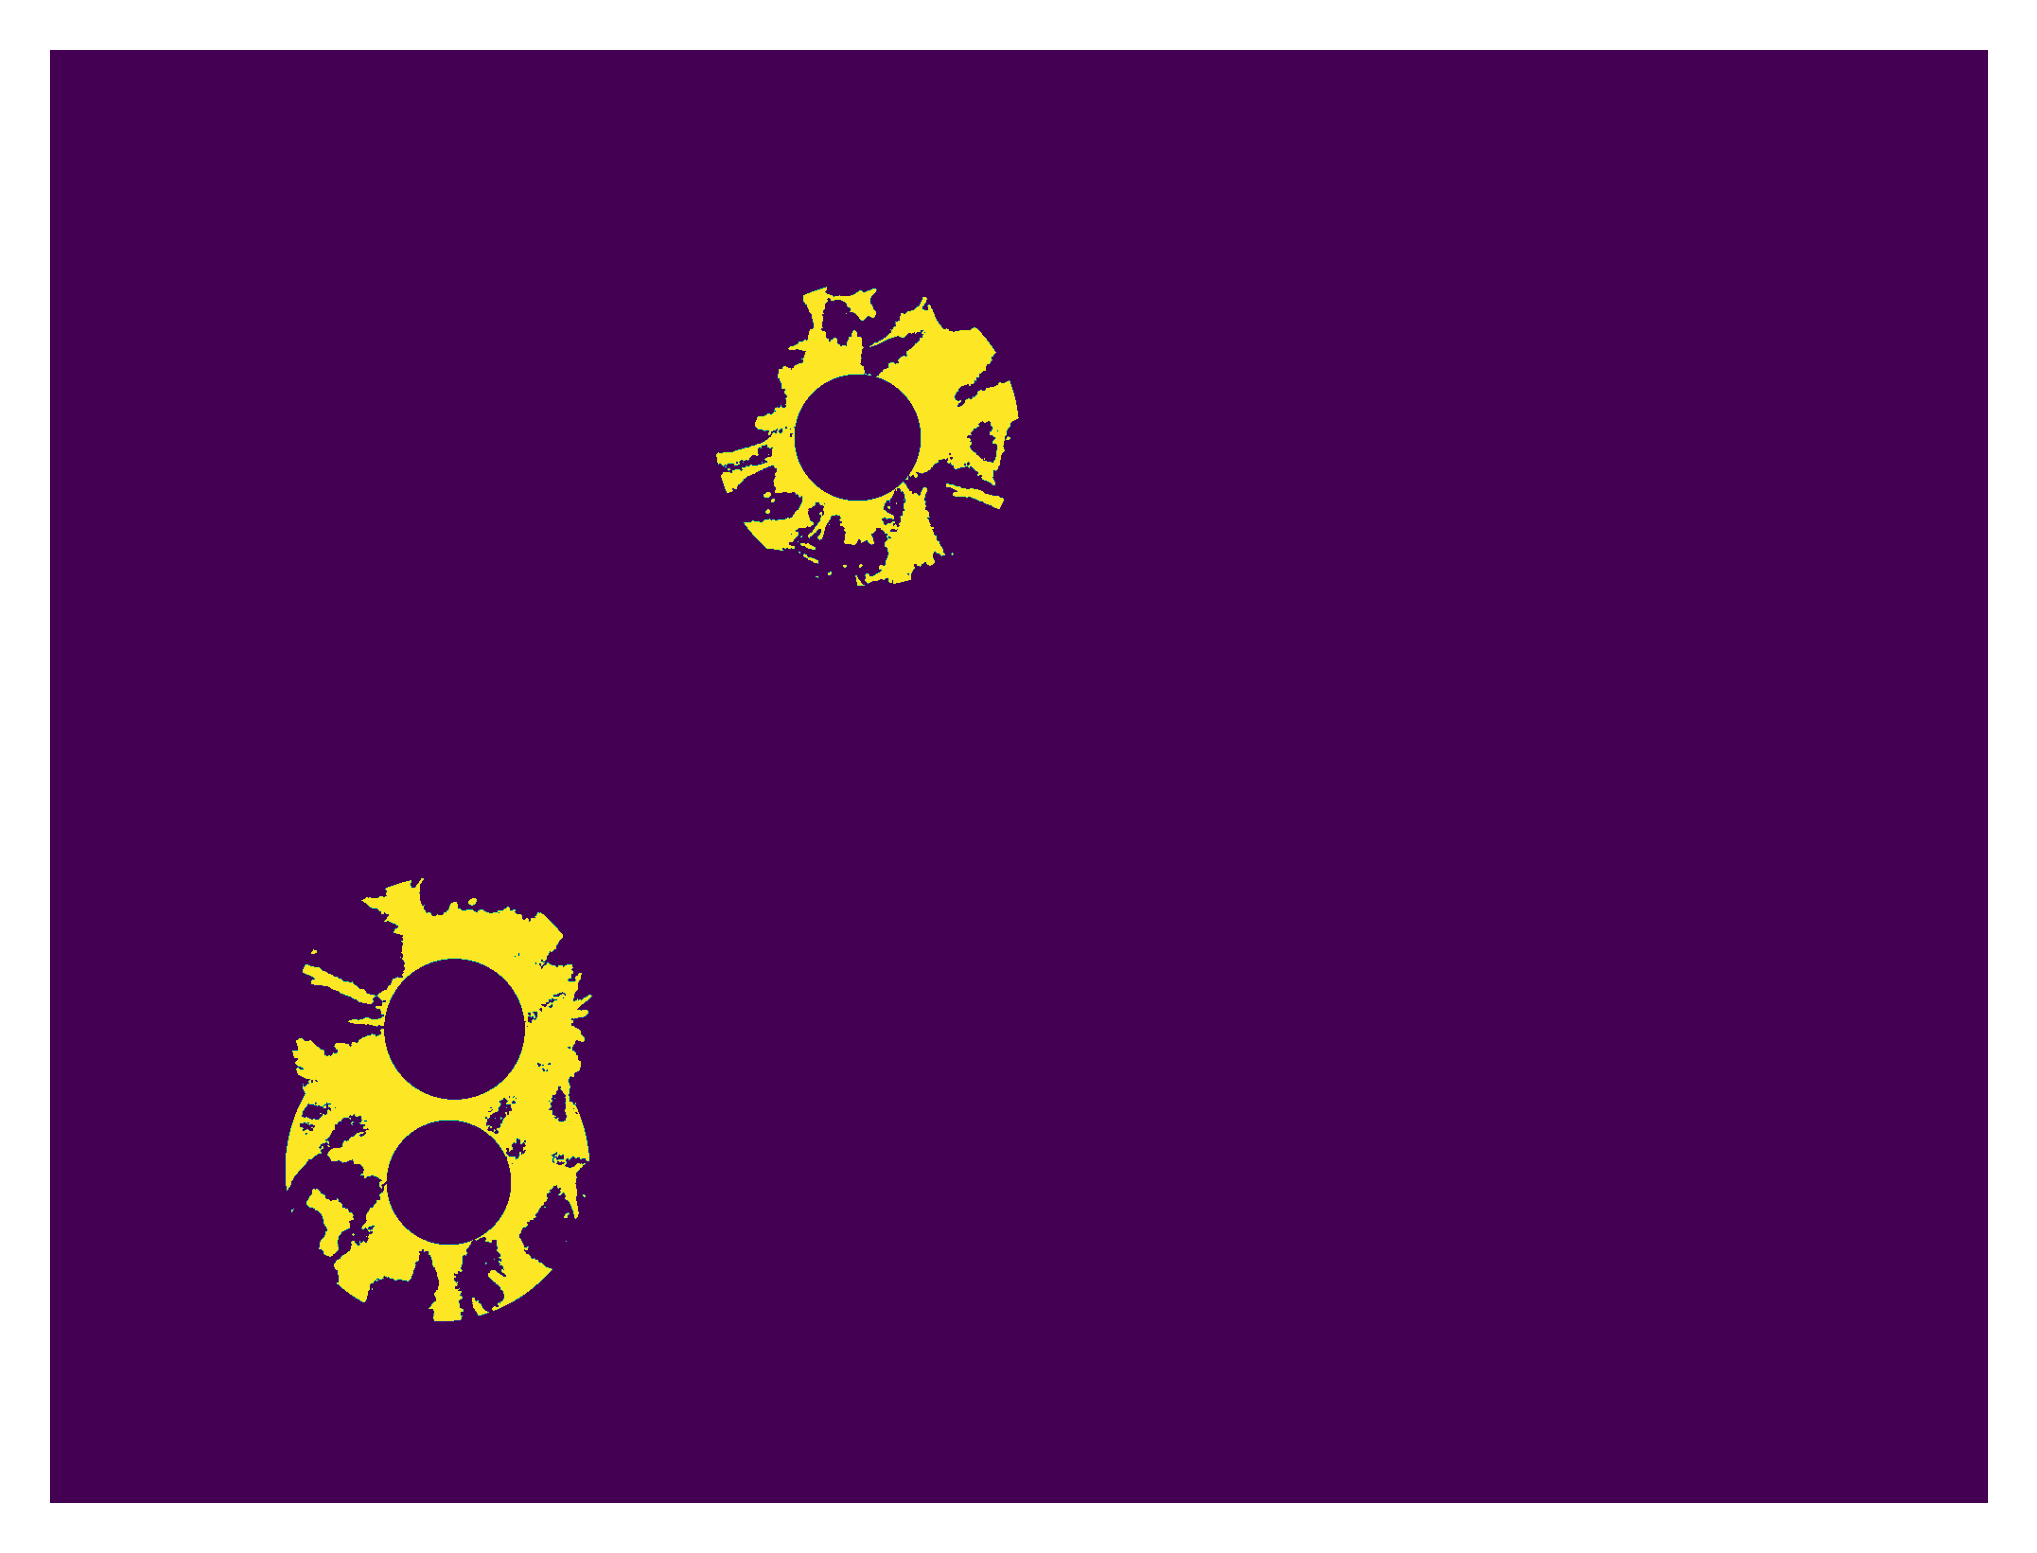

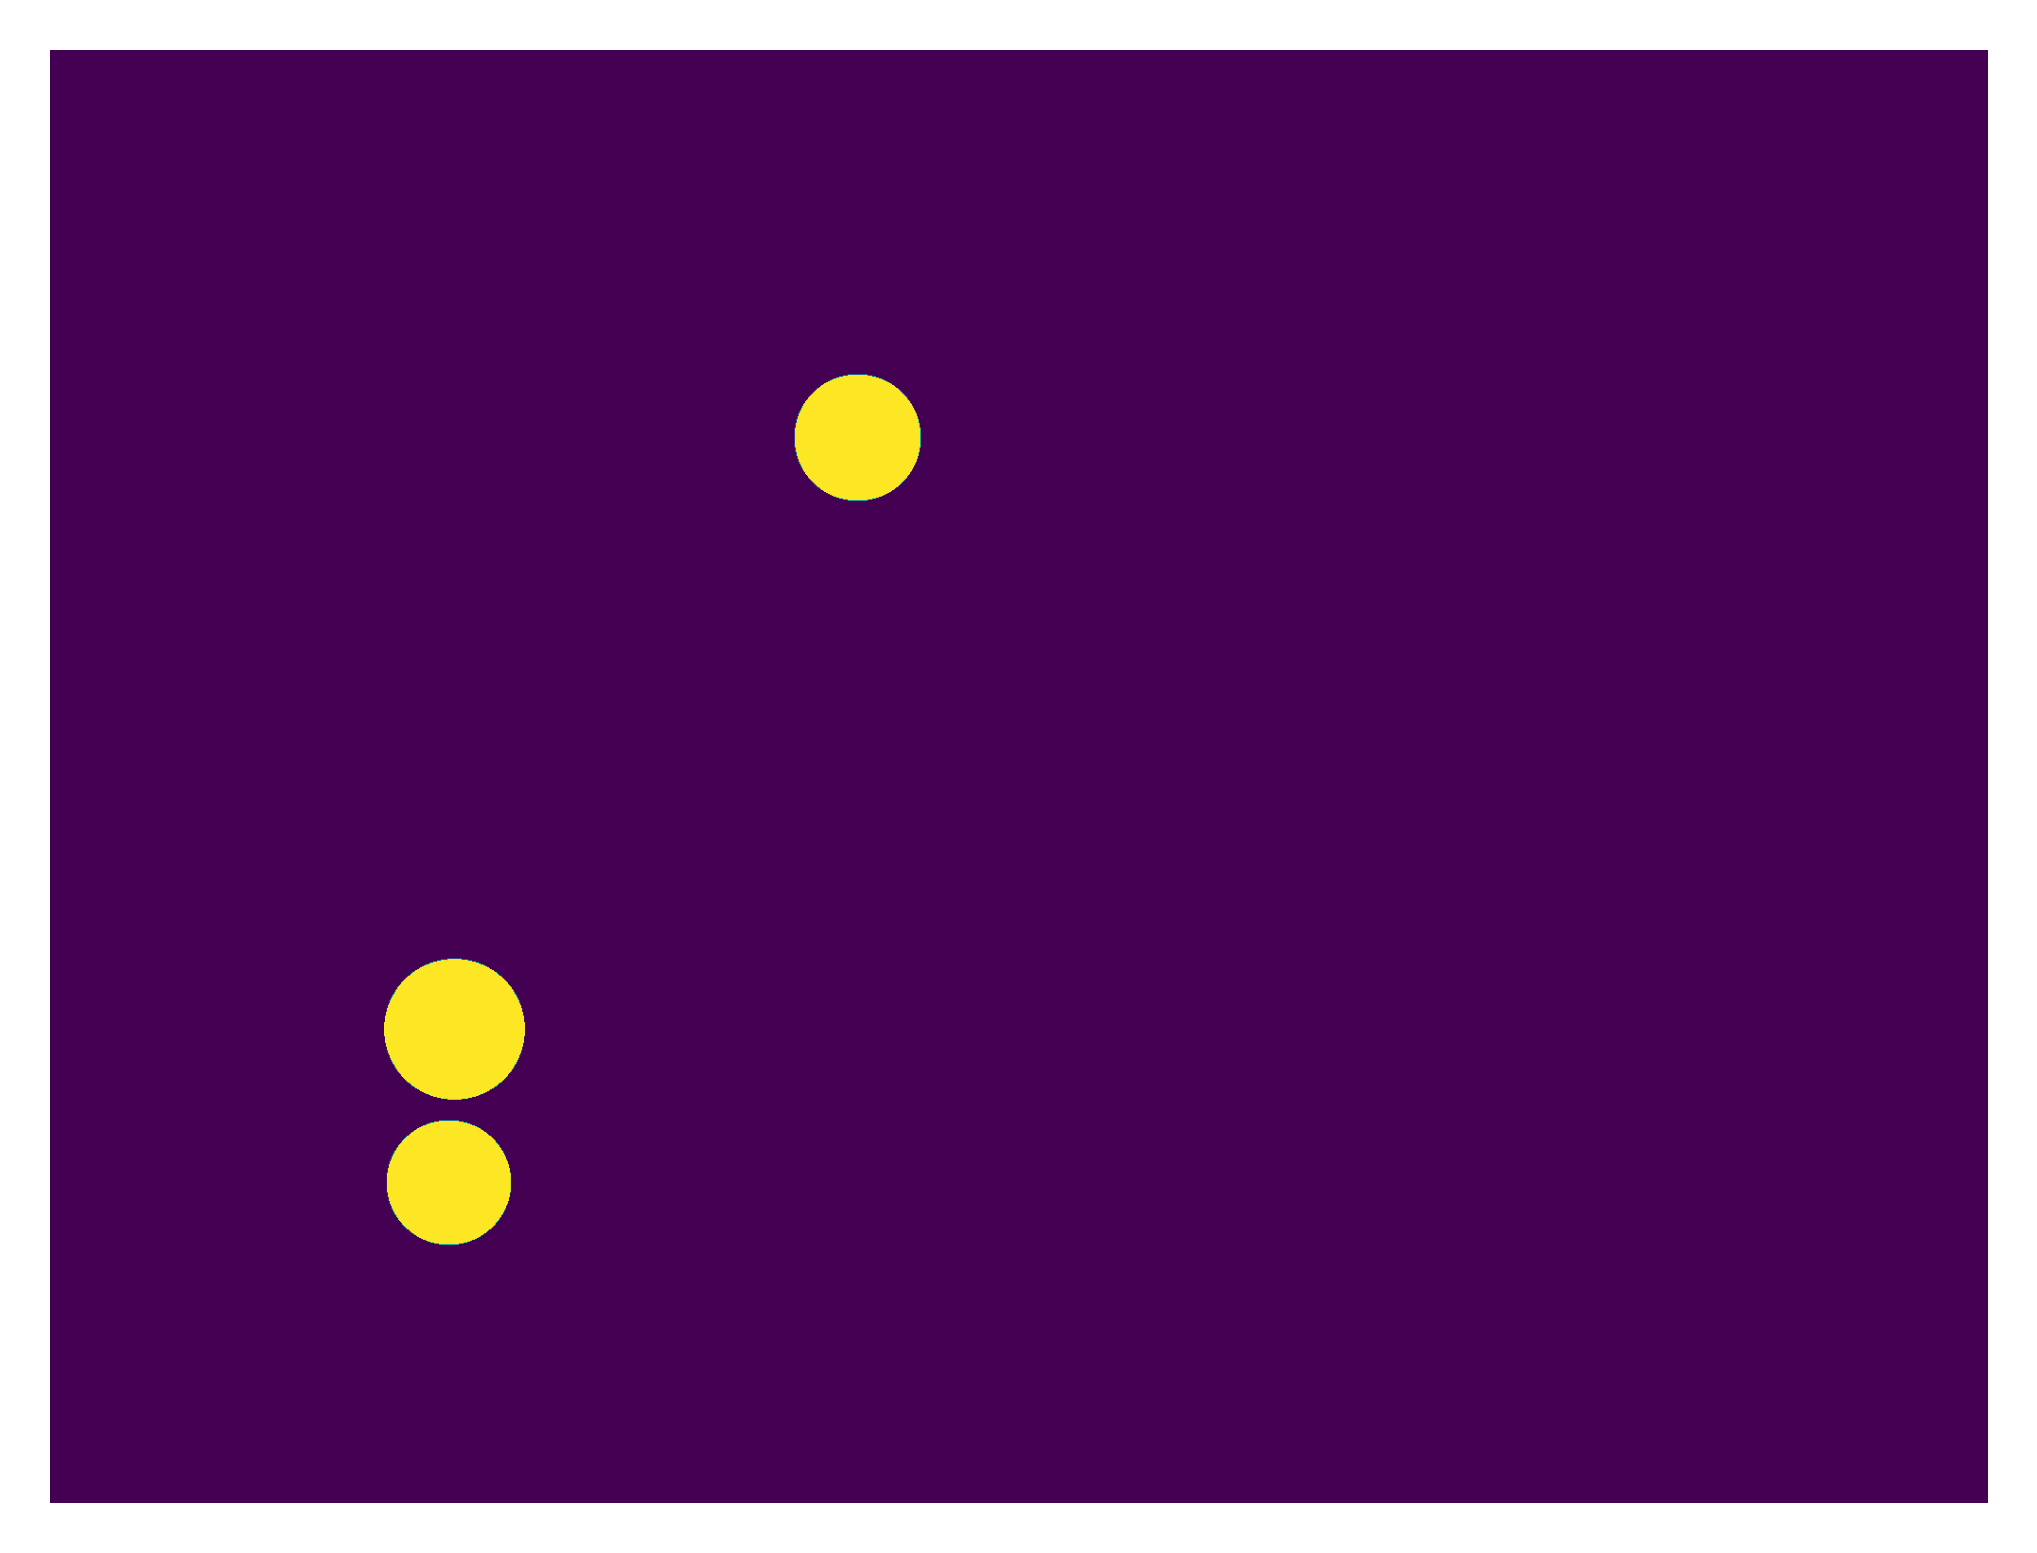

In [11]:
file_name = file_names[93]
m_img = io.imread(file_name)
spheroid_expansion_mask = find_spheroid_centroids(file_name, plot=True)

plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img[1]*(spheroid_expansion_mask>0))
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img[1])
plt.axis('off')
plt.show()


m_img_1_mask = io.imread(f'{file_name[:-4]}-adjust-masks.tif')
plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img_1_mask>0)
plt.axis('off')
plt.show()

## threshold cells
plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img_1_mask*(spheroid_expansion_mask>0)>0)
plt.axis('off')
plt.show()

m_img_1_mask_remove_cor,inner_core = remove_inner_cor(spheroid_expansion_mask,m_img_1_mask)
plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(m_img_1_mask_remove_cor*(spheroid_expansion_mask>0)>0)
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5), dpi=500)
plt.imshow(inner_core)
plt.axis('off')
plt.show()


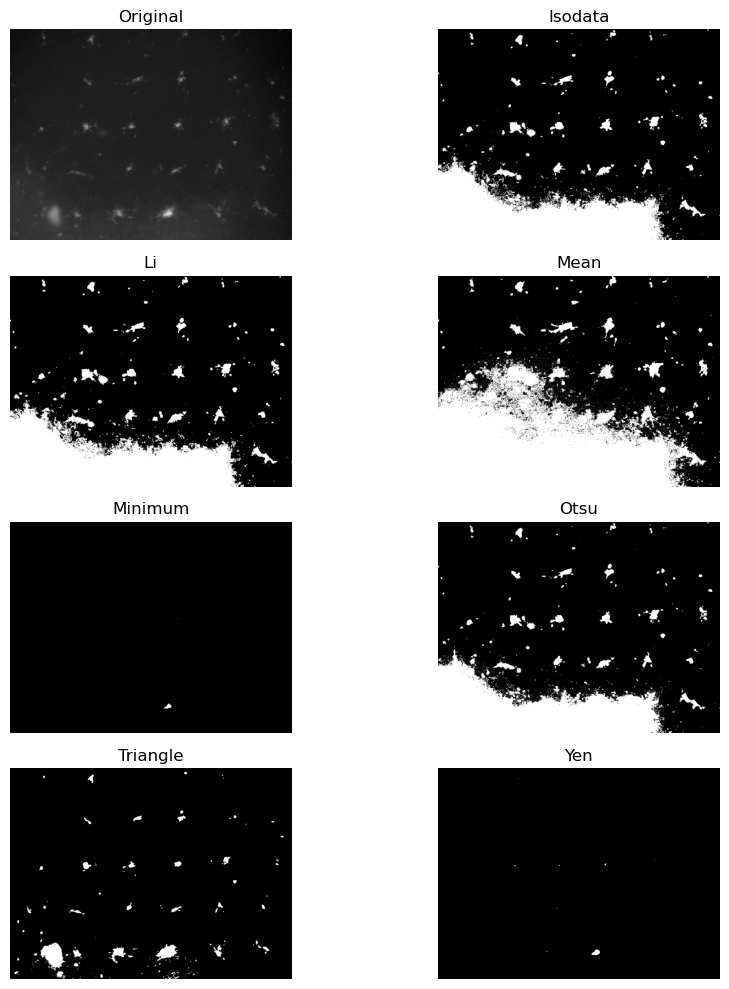

In [13]:
from skimage.filters import try_all_threshold
m_img_1_smooth = gaussian(m_img[1], sigma=1 , preserve_range=True)
fig, ax = try_all_threshold(m_img_1_smooth, figsize=(10, 10), verbose=False)
plt.show()

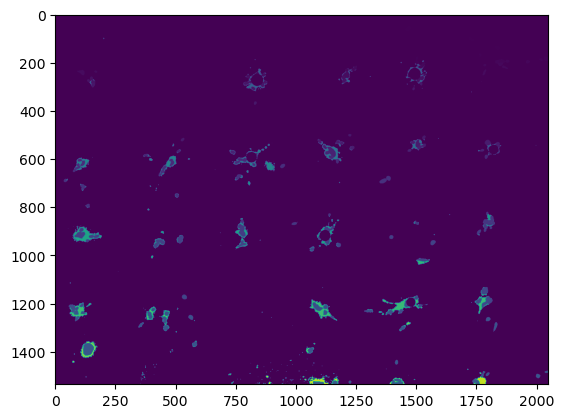

In [84]:
m_img_1_mask_remove_cor = remove_inner_cor(spheroid_expansion_mask,m_img_1_mask)
plt.imshow(m_img_1_mask_remove_cor)

In [79]:
## removing inner core of spheroid
regions = regionprops(spheroid_expansion_mask, intensity_image=m_img_1_mask)
m_img_1_mask_remove_cor = m_img_1_mask.copy()
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    tmp_label = label(props.image_intensity>0)
    tmp_centroid = np.array(tmp_label.shape) //2
    tmp_label_core = (tmp_label==tmp_label[tmp_centroid[0],tmp_centroid[1]])
    distance_transform = distance_transform_edt(tmp_label_core)
    max_radius = np.max(distance_transform)
    center_coords = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
    circle_image = np.zeros_like(tmp_label_core)
    rr, cc = disk(center_coords, max_radius, shape=circle_image.shape)
    circle_image[rr, cc] = 1  # Set the pixels within the circle to 1
    m_img_1_mask_remove_cor[minr:maxr, minc:maxc][circle_image] = 0


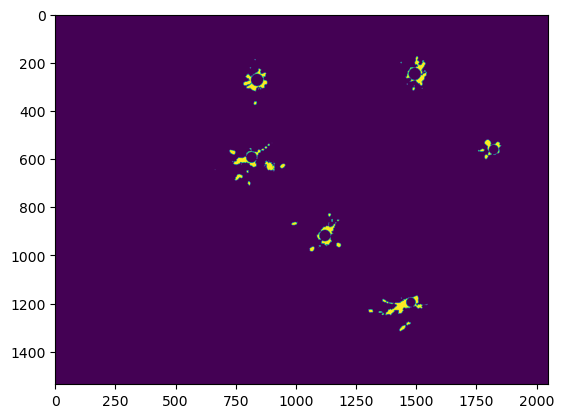

In [81]:
tmp_img = m_img_1_mask_remove_cor*spheroid_expansion_mask>0
plt.imshow(tmp_img)

In [72]:
np.array(props.image_intensity.shape)//2

array([47, 49])

In [49]:
regions = regionprops(label(m_img_1_mask*spheroid_expansion_mask), intensity_image=m_img[1])
for props in regions:
    if props.area > 2000:
        break

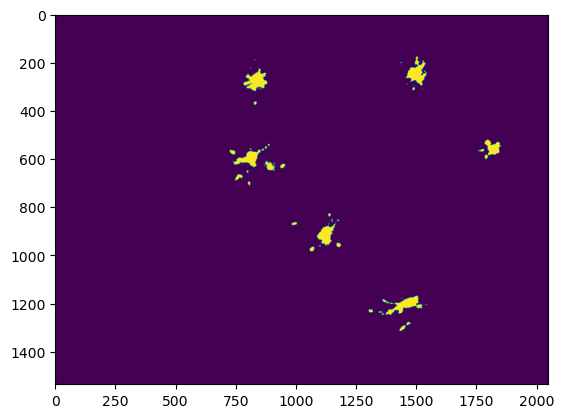

In [37]:
plt.imshow(label(m_img_1_mask*spheroid_expansion_mask)>0)

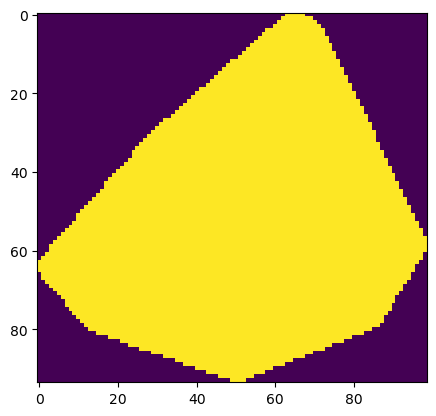

In [44]:
plt.imshow(props.image_convex)

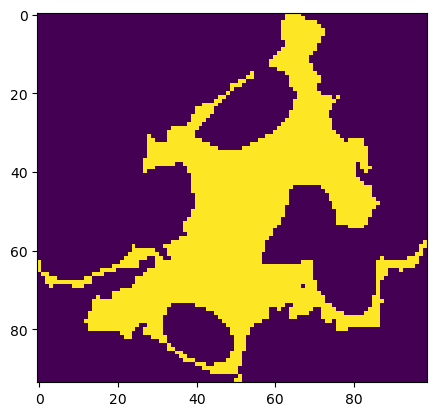

In [50]:
plt.imshow(props.image)

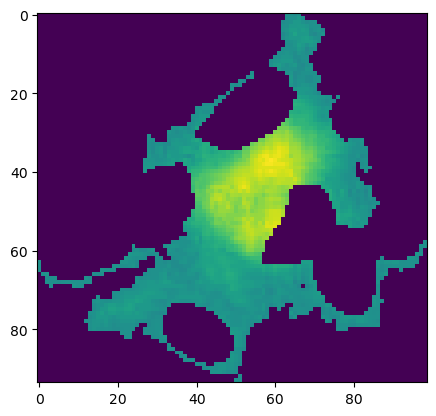

In [51]:
plt.imshow(props.image_intensity)

In [60]:
from scipy.ndimage import distance_transform_edt
from skimage.draw import disk

In [58]:
# Step 2: Compute the distance transform
distance_transform = distance_transform_edt(props.image)

# Step 3: Find the maximum value of the distance transform (this is the radius)
max_radius = np.max(distance_transform)

In [61]:
center_coords = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)

# Step 4: Create a blank image with the same shape as the input
circle_image = np.zeros_like(props.image)

# Step 5: Draw the circle with the found center and radius
rr, cc = disk(center_coords, max_radius, shape=circle_image.shape)
circle_image[rr, cc] = 1  # Set the pixels within the circle to 1

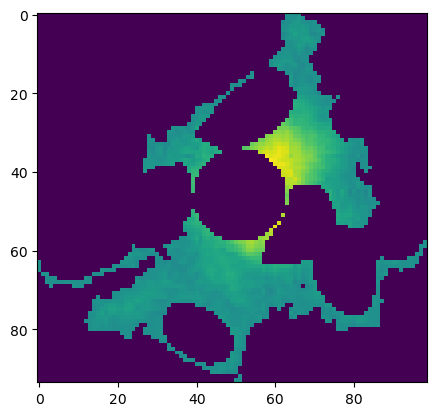

In [63]:
plt.imshow(props.image_intensity*(circle_image==0))